In [33]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [34]:
!pip install pmdarima

In [35]:
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# from pylab import rcParams
# rcParams['figure.figsize'] = 10, 6

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import requests

## Scraping NVIDIA Stock Data from Alpha Vantage

In [36]:
# Random seed for 
np.random.seed(42)

api_key = "SCX7GKIYACNHG3SL"  # API
api_url = f"https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=AAPL&outputsize=full&apikey={api_key}"

response = requests.get(api_url)
data = response.json()

time_series = data['Time Series (Daily)']
rows = []
for date, values in time_series.items():
    rows.append({
        'Date': date,
        'Open': float(values['1. open']),
        'High': float(values['2. high']),
        'Low': float(values['3. low']),
        'Close': float(values['4. close']),
        'Volume': int(values['5. volume'])
    })

df = pd.DataFrame(rows)
df = df.sort_values(by='Date')
df.to_csv('nvidia.us.txt', sep=',', index=False)

df.head()

,Date,Open,High,Low,Close,Volume
6398,1999-11-01,80.00,80.69,77.37,77.62,2487300
6397,1999-11-02,78.00,81.69,77.31,80.25,3564600
6396,1999-11-03,81.62,83.25,81.00,81.50,2932700
6395,1999-11-04,82.06,85.37,80.62,83.62,3384700
6394,1999-11-05,84.62,88.37,84.00,88.31,3721500


# Data Preprocessing

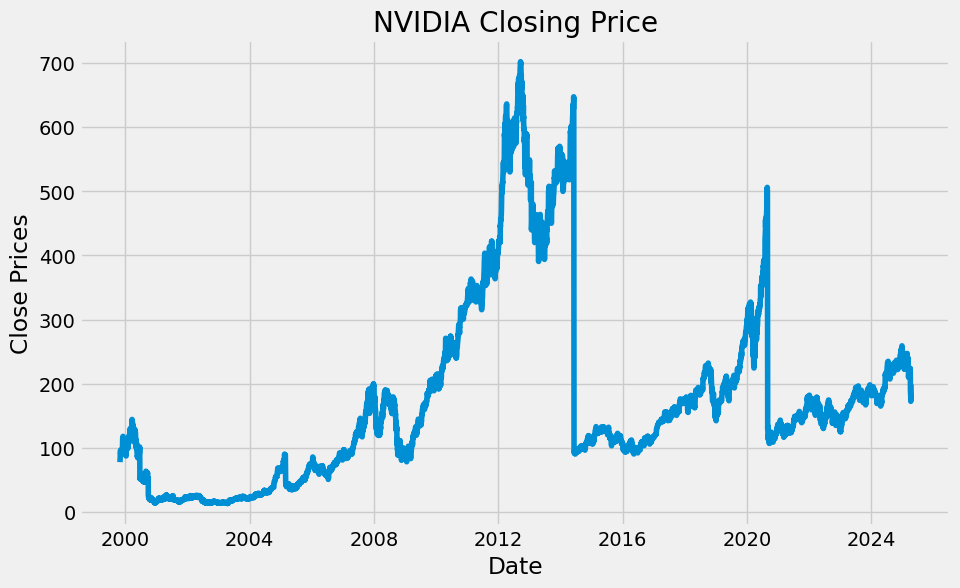

In [37]:
dateparse = lambda dates: pd.to_datetime(dates, format='%Y-%m-%d')
stock_data = pd.read_csv('nvidia.us.txt', sep=',', index_col='Date', parse_dates=['Date'], date_parser=dateparse)

# Forward-fill missing values
stock_data.fillna(method='ffill', inplace=True)

# Extraction of Close price
df_close = stock_data['Close']

# Plotting Close Price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(df_close)
plt.title('NVIDIA Closing Price')
plt.show()

# Tests

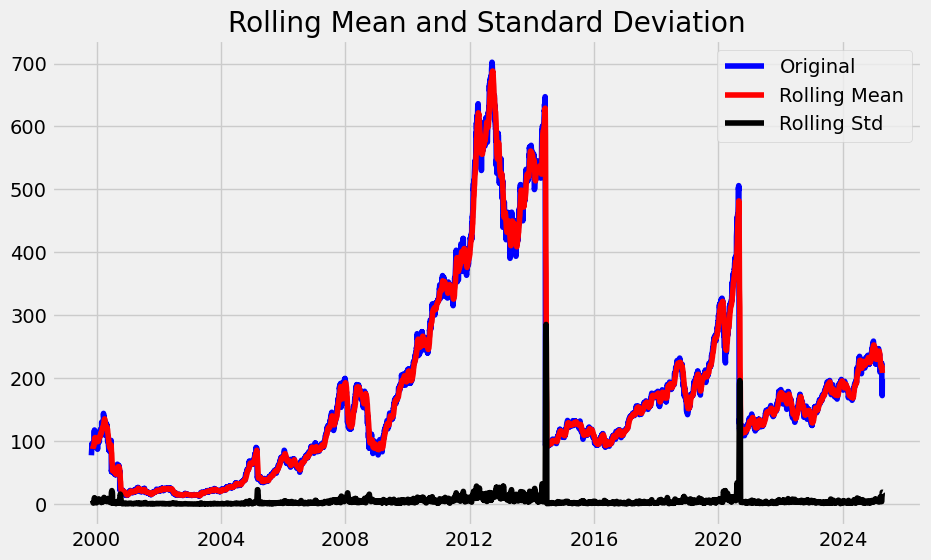

Results of Dickey-Fuller Test:
Test Statistic            -2.614789
p-value                    0.089979
#Lags Used                 0.000000
#Observations           6398.000000
Critical Value (1%)       -3.431372
Critical Value (5%)       -2.861992
Critical Value (10%)      -2.567011
dtype: float64


In [38]:
# Stationarity Test Function

def test_stationarity(timeseries):
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    plt.plot(timeseries, color='blue', label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show()

    print("Results of Dickey-Fuller Test:")
    adft = adfuller(timeseries, autolag='AIC')
    output = pd.Series(adft[0:4], index=['Test Statistic', 'p-value', '#Lags Used', '#Observations'])
    for key, value in adft[4].items():
        output[f'Critical Value ({key})'] = value
    print(output)

test_stationarity(df_close)

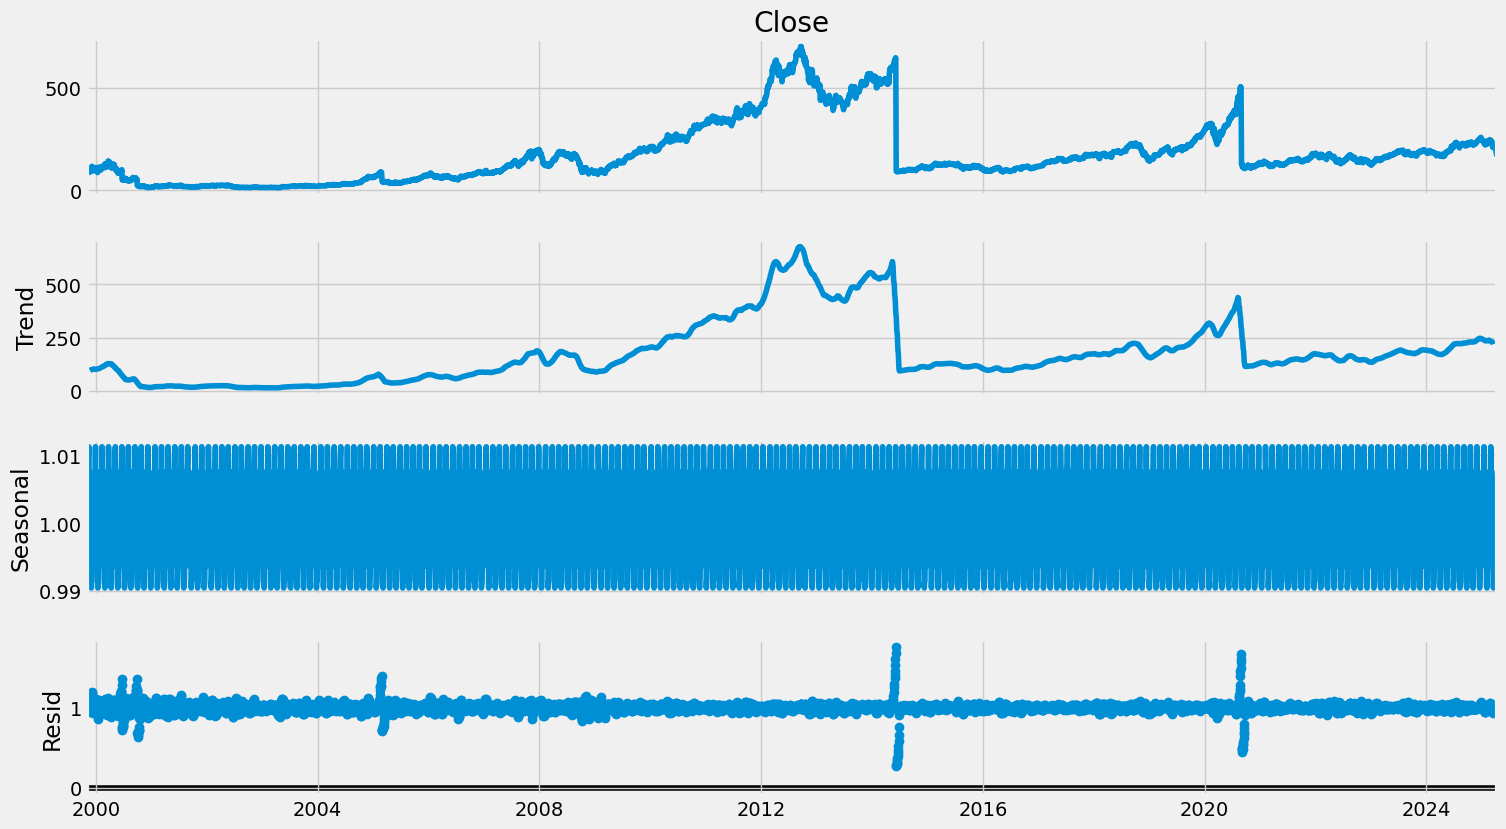

In [39]:
# Seasonal Decomposition
result = seasonal_decompose(df_close, model='multiplicative', period=30)
fig = result.plot()
fig.set_size_inches(16, 9)
plt.show()

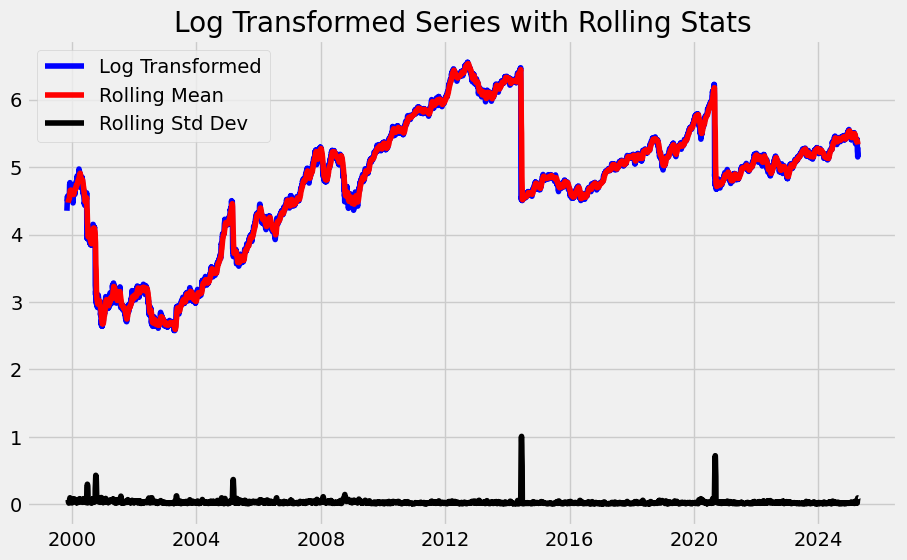

In [40]:
# Resample data to Business Days and Log Transform
df_close = df_close.sort_index().asfreq('B')
df_close.fillna(method='ffill', inplace=True)

df_log = np.log(df_close)

# Rolling Mean and Std Dev after Log Transform
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()

plt.plot(df_log, color='blue', label='Log Transformed')
plt.plot(moving_avg, color='red', label='Rolling Mean')
plt.plot(std_dev, color='black', label='Rolling Std Dev')
plt.legend()
plt.title('Log Transformed Series with Rolling Stats')
plt.show()

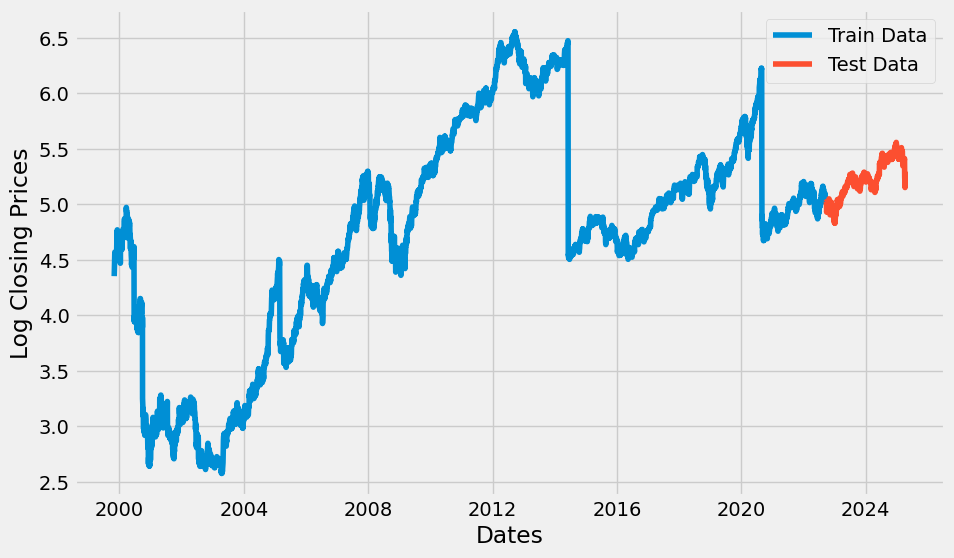

In [41]:
# Train-Test Split
split_idx = int(len(df_log) * 0.9)
train_data = df_log[:split_idx]
test_data = df_log[split_idx:]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Log Closing Prices')
plt.plot(train_data, label='Train Data')
plt.plot(test_data, label='Test Data')
plt.legend()
plt.show()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-21045.733, Time=0.61 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-21046.612, Time=0.47 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-21046.579, Time=0.62 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-21047.688, Time=0.48 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-21044.763, Time=0.84 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 3.039 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 5974
Model:               SARIMAX(0, 1, 0)   Log Likelihood               10524.844
Date:                Thu, 10 Apr 2025   AIC                         -21047.688
Time:                        09:55:45   BIC                         -21040.993
Sample:                    11-01-1999   HQIC                        -21045.363
                         - 09-22-2022                             

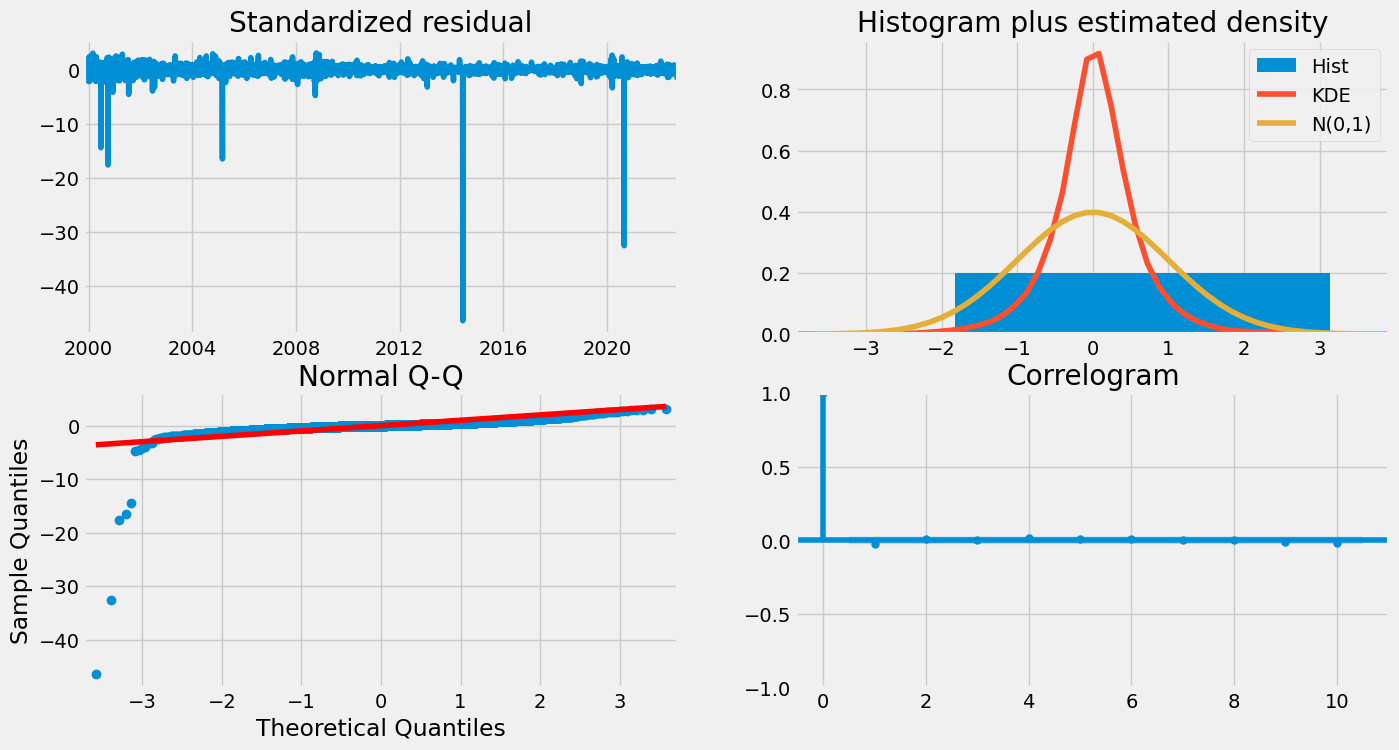

In [42]:
# Auto ARIMA Model Selection
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf', max_p=3, max_q=3,
                      m=1, d=None, seasonal=False,
                      trace=True, error_action='ignore',
                      suppress_warnings=True, stepwise=True)

print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [43]:
# Fit ARIMA Model using statsmodels
model = ARIMA(train_data, order=(1, 1, 2))
fitted = model.fit()
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 5974
Model:                 ARIMA(1, 1, 2)   Log Likelihood               10527.004
Date:                Thu, 10 Apr 2025   AIC                         -21046.008
Time:                        09:55:47   BIC                         -21019.228
Sample:                    11-01-1999   HQIC                        -21036.706
                         - 09-22-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7643      0.492      1.552      0.121      -0.201       1.729
ma.L1         -0.7867      0.492     -1.600      0.110      -1.751       0.177
ma.L2          0.0264      0.012      2.147      0.0

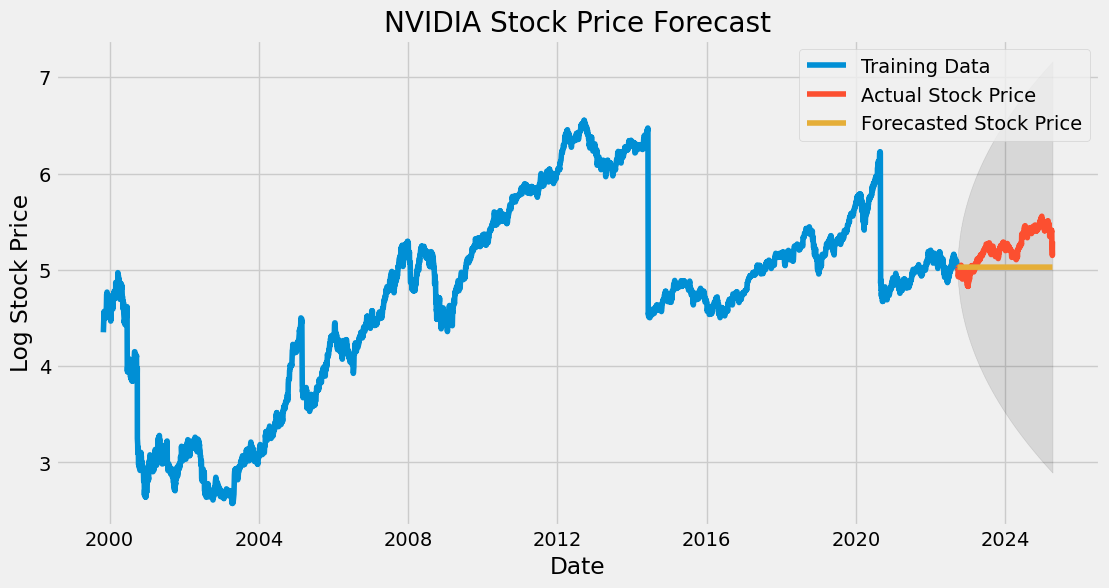

In [44]:
# Forecasting
forecast_steps = len(test_data)
forecast_result = fitted.get_forecast(steps=forecast_steps)

fc = forecast_result.predicted_mean
se = forecast_result.se_mean
conf = forecast_result.conf_int(alpha=0.05)

# Forecast Index
forecast_index = pd.date_range(start=test_data.index[0], periods=forecast_steps, freq='B')
fc_series = pd.Series(fc.values, index=forecast_index)

# Plotting Forecast
plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Training Data')
plt.plot(test_data, label='Actual Stock Price')
plt.plot(fc_series, label='Forecasted Stock Price')
plt.fill_between(forecast_index, conf.iloc[:,0], conf.iloc[:,1], color='k', alpha=0.1)
plt.title('NVIDIA Stock Price Forecast')
plt.xlabel('Date')
plt.ylabel('Log Stock Price')
plt.legend()
plt.show()

# Evaluation Metrics

In [45]:
# Align lengths for metric calculation
fc_aligned = fc_series[:len(test_data)]

mse = mean_squared_error(test_data, fc_aligned)
mae = mean_absolute_error(test_data, fc_aligned)
rmse = math.sqrt(mse)
mape = np.mean(np.abs(fc_aligned - test_data) / np.abs(test_data))

print(f'MSE: {mse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAPE: {mape:.4%}')

MSE: 0.0695
MAE: 0.2226
RMSE: 0.2636
MAPE: 4.1808%
